# Training

In this notebook, we are going to finetune models pretrained on ImageNet to our dataset. The code is very similar to the one in PyTorch tutorial; most changes are just modifications, that make the solution
compatible with our dataset (and our needs in general). This is also due to the fact that by using PyTorch we are restricted to use certain API and there aren't many good ways to write the same functionality.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.io as tio
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import os
import random

Set global constants

In [2]:
input_size = 224
num_classes = 5

### Data

We will be working with DataLoader API that PyTorch provides, as opposed to manually iterating over the dataset ourselves.

In [3]:
data_dir = "../data/split/"
batch_size = 4

In [4]:
# Dataset is already preprocessed, we just need to normalize it (to be compatible with pretrained models)
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create training and validation datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms)
}


# Create training and validation dataloaders
dataloaders_dict = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=4)
}

# Use GPU if possible (note that this would require to install GPU compatible version of PyTorch contrary to the installation description in README.md)
# We keep it here because it's generally a good practice to let anyone decide, whether he prefers to use CPU or GPU (making the code more general)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Models

We are going to finetune three pretrained models - resnet, vgg and densenet. We will also train a simple convnet from scratch.

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, (5, 5))
        self.pool1 = nn.MaxPool2d((2,2), 2)
        
        self.conv2 = nn.Conv2d(16, 16, (3, 3))
        self.pool2 = nn.MaxPool2d((2,2), 2)
        
        self.conv3 = nn.Conv2d(16, 32, (3, 3))
        self.pool3 = nn.MaxPool2d((2,2), 2)
        
        self.conv4 = nn.Conv2d(32, 32, (3, 3))
        self.pool4 = nn.MaxPool2d((2,2), 2)
        
        self.conv5 = nn.Conv2d(32, 64, (3, 3))
        self.pool5 = nn.MaxPool2d((2,2), 2)
        
        self.conv6 = nn.Conv2d(64, 64, (3, 3))
        self.pool6 = nn.AdaptiveMaxPool2d((1,1))
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        x = F.relu(self.pool4(self.conv4(x)))
        x = F.relu(self.pool5(self.conv5(x)))
        x = F.relu(self.pool6(self.conv6(x)))
        x = x.squeeze(-1).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return x

In [6]:
model_names = [
    'convnet',
    'resnet',
    'vgg',
    'densenet'
]

We will only want to train the last layer.

In [7]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

Get pretrained model, forbid gradients of it's weights, replace last layer with new one (of correct size).

In [8]:
def get_pretrained_model(model_name):
    model_ft = None

    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=True)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=True)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained=True)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "convnet":
        model_ft = ConvNet()

    return model_ft

### Training

First, we are going to implement the main training loop.

In [9]:
def train(model, dataloaders, loss_fn, optimizer, num_epochs=25):
    print_step = num_epochs // 5
    
    losses_train = [0]
    losses_val = [0]
    
    # Compute training and validation loss prior to the training
    for phase in ["train", "val"]:
        model.eval()
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                # Note that the loss here is an AVERAGE, not a sum of individual losses (across minibatch)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                if phase == 'train':
                    # Average -> sum
                    losses_train[0] += loss.item() * inputs.size(0)
                else:
                    # Average -> sum
                    losses_val[0] += loss.item() * inputs.size(0)

        # Compensate for different sizes of datasets
        if phase == "train":
            losses_train[0] = losses_train[0] / len(dataloaders[phase].dataset)
        else:
            losses_val[0] = losses_val[0] / len(dataloaders[phase].dataset)
    
    # Training loop
    for epoch in range(num_epochs):
        if ((epoch+1) % print_step == 0):
            print("Epoch:", epoch+1)
        
        losses_train.append(0)
        losses_val.append(0)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Note that the loss here is an AVERAGE, not a sum of individual losses (across minibatch)
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        # Average -> sum
                        losses_train[-1] += loss.item() * inputs.size(0)
                    else:
                        # Average -> sum
                        losses_val[-1] += loss.item() * inputs.size(0)
            
            # Compensate for different sizes of datasets
            if phase == "train":
                losses_train[-1] = losses_train[-1] / len(dataloaders[phase].dataset)
            else:
                losses_val[-1] = losses_val[-1] / len(dataloaders[phase].dataset)
            
    return losses_train, losses_val

Now we are going to instantiate individual networks and train them.

In [10]:
networks = []
for m_name in model_names:
    networks.append(get_pretrained_model(m_name))

In [11]:
optimizer_conf = {
    'convnet': {
        'lr': 0.001,
        'momentum': 0.9
    },
    'resnet': {
        'lr': 0.0005,
        'momentum': 0.9
    },
    'vgg': {
        'lr': 0.0005,
        'momentum': 0.9
    },
    'densenet': {
        'lr': 0.0005,
        'momentum': 0.9
    }
}

optimizers = []
for idx in range(len(networks)):
    networks[idx] = networks[idx].to(device)

    params_to_update = []
    for name,param in networks[idx].named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

    optimizers.append(optim.SGD(
        params_to_update, 
        lr=optimizer_conf[model_names[idx]]["lr"], 
        momentum=optimizer_conf[model_names[idx]]["momentum"]
    ))

In [12]:
epochs_conf = {
    'convnet': 250,
    'resnet': 25,
    'vgg': 25,
    'densenet': 25
}

loss_fn = nn.CrossEntropyLoss()

loss_train = dict()
loss_val = dict()
for idx, model in enumerate(networks):
    print("Training model:", model_names[idx])
    optimizer = optimizers[idx]
    num_epochs = epochs_conf[model_names[idx]]
    lt, lv = train(model, dataloaders_dict, loss_fn, optimizer, num_epochs)
    
    loss_train[model_names[idx]] = lt 
    loss_val[model_names[idx]] = lv 

Training model: convnet
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Training model: resnet
Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Training model: vgg
Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Training model: densenet
Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25


### Results

Let's analyze if the networks managed to converge and how good they are. First, we are going to look at the both training and validation loss development in time. For each model, we have one such graph.

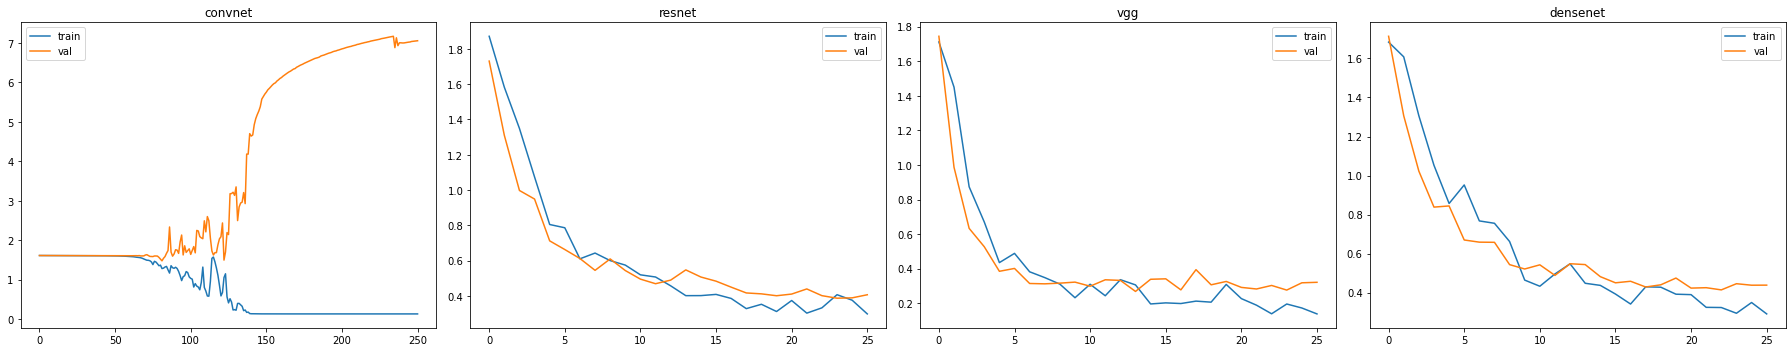

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25,5))
for idx, name in enumerate(model_names):
    axes[idx].plot(loss_train[name], label="train")
    axes[idx].plot(loss_val[name], label="val")
    axes[idx].legend()
    axes[idx].set_title(name)
    
fig.tight_layout()

Except convnet, all the models converged to some solution (this is probably due to really small number of examples, which leads to overfittting).
We can compare validation errors of individual networks.

In [19]:
for name in model_names:
    print(name, ":", loss_val[name][-1])

convnet : 7.057586443424225
resnet : 0.4060492992401123
vgg : 0.32101842761039734
densenet : 0.4382042191922665


VGG looks like a clear winner here. Now we would like to see what do the networks actually output for the validation data. We are going to investigate the number of correctly / incorrectly classified examples for each model.

In [15]:
for idx, name in enumerate(model_names):
    model = networks[idx]
    
    correct = 0
    incorrect = 0
    for inputs, labels in dataloaders_dict['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct += torch.sum(labels == preds).item()
            incorrect += torch.sum(labels != preds).item()
            
    print(name, ":", correct, "/", incorrect)

convnet : 8 / 12
resnet : 16 / 4
vgg : 19 / 1
densenet : 17 / 3


We can compare this to uniformly random selection of class, which would on average result in 4 / 16 - surprisingly, convnet got better resuls than random, even though we've seen it overfitted the training data. Again, VGG scores the best. 

Lastly, we will look at several examples, that is what individual models predict for them.

In [16]:
class_to_index = image_datasets['train'].class_to_idx
index_to_class = [""]*5
for key in class_to_index:
    val = class_to_index[key]
    index_to_class[val] = key

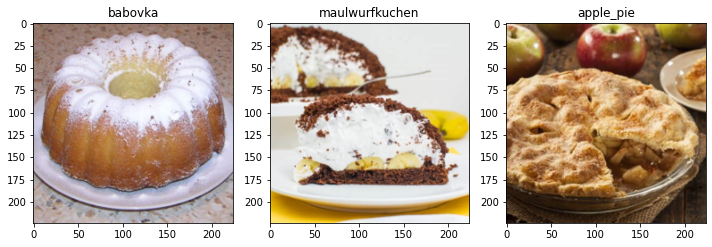

In [17]:
examples = [
    ("../data/split/val/babovka/26.png", "babovka"),
    ("../data/split/val/maulwurfkuchen/26.png", "maulwurfkuchen"),
    ("../data/split/val/apple_pie/25.png", "apple_pie")
]

images = [(tio.read_image(x),y) for (x,y) in examples]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
for idx, im in enumerate(images):
    image, label = im
    axes[idx].imshow(transforms.functional.to_pil_image(image))
    axes[idx].set_title(label)
    
fig.tight_layout()

In [18]:
for idx, name in enumerate(model_names):
    print("Model:", name)
    model = networks[idx]
    
    for im in images:
        image, label = im
        image = data_transforms(transforms.functional.to_pil_image(image))
        image = image.unsqueeze(0).to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            print("    - true:", label, ", predicted:", index_to_class[preds.item()])


Model: convnet
    - true: babovka , predicted: babovka
    - true: maulwurfkuchen , predicted: cheesecake
    - true: apple_pie , predicted: apple_pie
Model: resnet
    - true: babovka , predicted: babovka
    - true: maulwurfkuchen , predicted: cheesecake
    - true: apple_pie , predicted: apple_pie
Model: vgg
    - true: babovka , predicted: babovka
    - true: maulwurfkuchen , predicted: maulwurfkuchen
    - true: apple_pie , predicted: apple_pie
Model: densenet
    - true: babovka , predicted: babovka
    - true: maulwurfkuchen , predicted: maulwurfkuchen
    - true: apple_pie , predicted: apple_pie


It is interesting to note that the second picture was mistaken for cheesecake by two networks. I encourage the reader to look at the examples of
cheesecake and maulwurfkuchen in the dataset to see, why that might be the case (for this particular example).